### Work in Progress...

# Garments Production

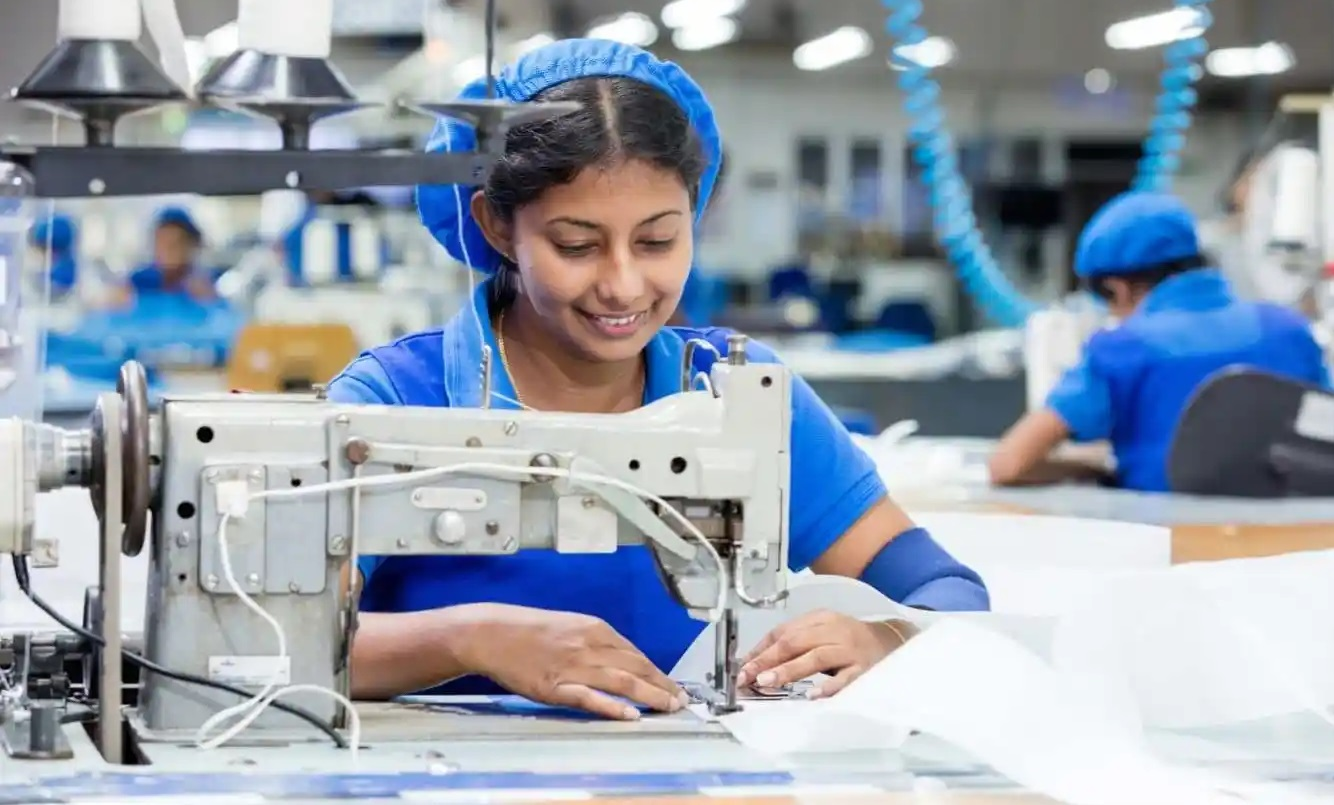

`Attribute Information:`

1. date : Date in MM-DD-YYYY
2. day : Day of the Week
3. quarter : A portion of the month. A month was divided into four quarters
4. department : Associated department with the instance
5. team : Associated team number with the instance
6. no_of_workers : Number of workers in each team
7. no_of_style_change : Number of changes in the style of a particular product
8. targeted_productivity : Targeted productivity set by the Authority for each team for each day.
9. smv : Standard Minute Value, it is the allocated time for a task
10. wip : Work in progress. Includes the number of unfinished items for products
11. overtime : Represents the amount of overtime by each team in minutes
12. incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
13. idletime : The amount of time when the production was interrupted due to several reasons
14. idlemen : The number of workers who were idle due to production interruption
15. actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

# Load Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')
print(df.shape)
df.head()

(1197, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


# EDA
Inspect, Clean, and Validate.
Show underlying patterns and relationships within datasets.

#### Dataset general information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

`task:`

Work in Progress... 

1. 
2. 
3. 

### Rename department column wrong typo's and convert to categorical dtypes

In [4]:
df.department.value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [5]:
df['department'] = df['department'].replace(['sweing'], 'sewing')
df['department'] = df['department'].replace(['finishing '], 'finishing')
df['department'] = df.department.astype('category')

df.department.value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

### Duplicates

In [6]:
# variable that store duplicates exactly the same as another row
dups = df.duplicated()
# count duplicates
dups.value_counts()

False    1197
dtype: int64

Theres no duplicates.

### Clean the Data (Null Values)

Check for the frequency of nulls in all the columns

In [7]:
df.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

Theres a large proportion of null values in `wip`(42%). The first approach is to investigate how this data was collected or structured.

We need to undestand what type of missing data we are dealing:
- Structurally missing data
- Missing Completely at Random (MCAR)
- Missing at Random (MAR)
- Missing Not at Random (MNAR)

Check the shape of finishing and sewing department seperately.

In [8]:
finishing = df[df['department']=='finishing']
sewing = df[df['department']=='sewing']

print(finishing.shape)
sewing.shape

(506, 15)


(691, 15)

Check the total number of nulls in wip.

In [9]:
finishing.wip.isna().sum()

506

Nova! all of the NaN entries are comming from `finishing` department. What we need to so now is to ask and verify if there is really no pending works(wip) in the finishing department, just to be sure. Since there is no one to ask for this project I will conclude that this missing data is labeled as `Structurally Missing` thus there is no wip in the finishing department. 

Now were gonna impute these NaN values. We have a lot of techniques in imputing Nan's (ex. time series LOCF and NOCB, pairwise, listwise etc.) in this scenario we will convert these NaN in to zero.

In [10]:
# Converting wip NaN values to zero
df.wip.fillna(0, inplace=True)

#### Visualize the null datapoints

We convert first all nulls into 0 before plotting thats because matplot library does'nt read nulls so if we plot our variables without converting, null will not show in the plot. 

In [11]:
# Code preparation for plotting.
# Mapping departent to 0 and 1 as integer 
df['dept_mapped'] = df.department.map({
                                'finishing':0,
                                'sewing':1})
# convert to int dtype
df.dept_mapped  = df.dept_mapped.astype('int64')

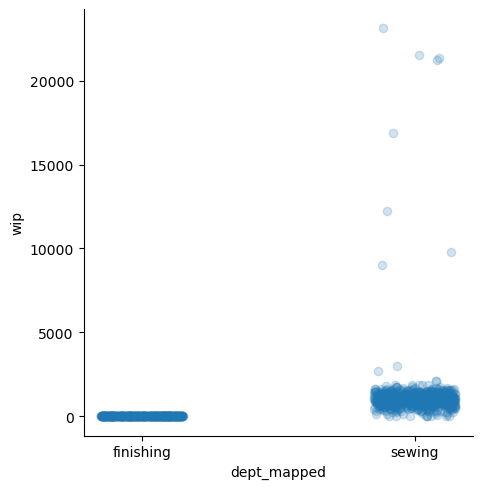

In [12]:
# plt.figure(figsize=(1, 1)) 
g = sns.lmplot(x='dept_mapped', y='wip', 
               data=df, 
               x_jitter=0.15, 
               y_jitter=0.15, 
               fit_reg=False, 
               scatter_kws={'alpha':0.2})

g.set(xticks=range(2))
g.set_xticklabels(['finishing', 'sewing'])
plt.show()

### Convert date to datetime dtype

In [13]:
# date format is MM-DD-YYYY
df['date'] = pd.to_datetime(df.date, format="%m/%d/%Y")

Augment data with additional columns(add month and work_week) 

In [14]:
# add month
df['month'] = df['date'].dt.month

In [15]:
# Adding `work_week` columns. It's easier to analyze production data per work week.
# create a list of our conditions
conditions = [
    
    #January
    (df['month'] == 1) & (df['quarter'] == 'Quarter1'), #ww1
    (df['month'] == 1) & (df['quarter'] == 'Quarter2'), #ww2
    (df['month'] == 1) & (df['quarter'] == 'Quarter3'), #ww3
    (df['month'] == 1) & (df['quarter'] == 'Quarter4'), #ww4
    (df['month'] == 1) & (df['quarter'] == 'Quarter5'), #ww4
    
    #February
    (df['month'] == 2) & (df['quarter'] == 'Quarter1'), #ww5
    (df['month'] == 2) & (df['quarter'] == 'Quarter2'), #ww6
    (df['month'] == 2) & (df['quarter'] == 'Quarter3'), #ww7
    (df['month'] == 2) & (df['quarter'] == 'Quarter4'), #ww8
    (df['month'] == 2) & (df['quarter'] == 'Quarter5'), #ww8
    
    #March
    (df['month'] == 3) & (df['quarter'] == 'Quarter1'), #ww9
    (df['month'] == 3) & (df['quarter'] == 'Quarter2'), #ww_10
    (df['month'] == 3) & (df['quarter'] == 'Quarter3'), #ww_11
    (df['month'] == 3) & (df['quarter'] == 'Quarter4'), #ww_12
    (df['month'] == 3) & (df['quarter'] == 'Quarter5'), #ww_12
    ]

values = ['ww1','ww2','ww3','ww4','ww4',
          'ww5','ww6','ww7','ww8','ww8',
          'ww9','ww_10','ww_11','ww_12','ww_12']

df['work_week'] = np.select(conditions, values)

### Quater column to categorical dtypes

In [16]:
quarter_order = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5' ]
df.quarter = pd.Categorical(df.quarter, quarter_order, ordered=True)
# verify quarter order
df.quarter.unique()

['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']
Categories (5, object): ['Quarter1' < 'Quarter2' < 'Quarter3' < 'Quarter4' < 'Quarter5']

###  Day column to categorical dtypes

In [17]:
df.day.unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [18]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday' ]
df.day = pd.Categorical(df.day, day_order, ordered=True)
# verify day order
df.day.unique()

['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
Categories (6, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Saturday' < 'Sunday']

### Inspect zero value (60% and up) 
Let's investigate this zero values.

In [19]:
# how many zeros are there in each columns?
# (df == 0).sum(axis=0) # uncomment to show result

print('Proportion of zeros: ')
(df == 0).sum(axis=0)  / len(df) * 100

Proportion of zeros: 


date                      0.000000
quarter                   0.000000
department                0.000000
day                       0.000000
team                      0.000000
targeted_productivity     0.000000
smv                       0.000000
wip                      42.272348
over_time                 2.589808
incentive                50.459482
idle_time                98.496241
idle_men                 98.496241
no_of_style_change       87.719298
no_of_workers             0.000000
actual_productivity       0.000000
dept_mapped              42.272348
month                     0.000000
work_week                 0.000000
dtype: float64

We have a very large proportion of zero value in `wip`, `incentive`, `idle_time`, `idle_men`,  and `no_of_style_change `.

- `wip ` This 42% of zeros are came from finishing department alternately the remaining 58% are work in progress by the sewing department.
- `incentive` 50% or half of the total production days got incentive
- `idle_time ` This large proportion is a good indication that the the production is running smoothly.
- `idle_men` Same as idle_time, most of the teams/workers are working deligently. 98% are zero value.
- `no_of_style_change ` 87.72% are zero values. Seems fair there is only 12% of change of product style that caused idle_time. Changing style might result to idle_time if not properly executed. 

### Statistical Analysis
After doing some cleaning and data wrangling, we can now plot the histogram of the dataset for inspection.

- Central Tendency
- Spread of quantitative variables



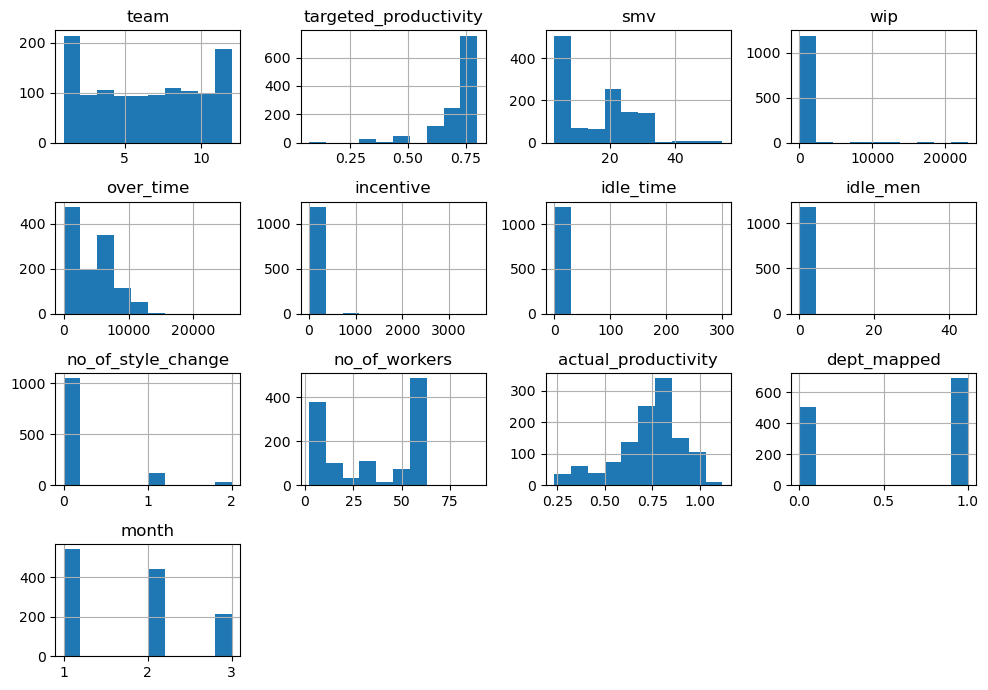

In [20]:
# we will not include date in this visualization
df.drop(columns=['date']).hist(figsize=(10, 7))
plt.tight_layout()
plt.show()

### Work in progress...

1. `team`s seems fairly distributed and flat
   - Whats the best team so far?


2. `target productivity` heavily left skewed which is a great. Target productivy should have more high values.
   - Predicted vs. actual productivity


3. `smv` distribution is faily symmetrical
   - Check if theres variables correlated to smv(ex. Is low smv(allocated time for a task) correlate to over_time?


4. `wip` heavily right skewed, as seen in above graph most of the datapoints are at zero only few has value. Kurtosis at 110 indicating that the distribution is very tall(the mode has a very high proportion).



5. `over_time` moderately right skewed. Also a good sign, we must lessen OT while maintenaning high productivity.
    -  How much over_time does production have per work_week? Also the number of workers?


6. `incentive` heavily right skewed, most observation don't have incentives. Kurtosis at very high value(299) indicating that theres a large proportion of one observation(it is zero value). We should do an investigation with the outliers.
    - Is this high value incentives has correlation with actual_productivy?

7. `idle_time` highly left skewed, we have 98% zero idle time.
    - In what work_week does e have idle_time?


8. `no_of_worker` looks like a bimodal distribution, <font color='red'>we can form a clusters/groups for this kind of  distribution.</font>



9. `Actual_productiviy` moderately left skewed. This is a good sign.




####  Skewness
Skewness is a measure of asymmetry of a distribution.
`Important Notes:`
-  between -0.5 and 0.5, fairly symmetrical
-  between -1 and -0.5 or between 0.5 and 1, moderately skewed
-  less than -1 or greater than 1,  highly skewed

In [ ]:
# select numeric columns only
df_numeric = df.select_dtypes(include=np.number).columns.tolist()
for i in df_numeric:
    print(i + ' ==> ' + str(round(df[i].skew(),2)))

#### Kurtosis() 
kurtosis determines the heaviness of the distribution tails. Determine the volume of the outlier.
- If the distribution is tall and thin it is called a `leptokurtic` distribution(Kurtosis > 3). Values in a leptokurtic distribution are near the mean or at the extremes.
- A flat distribution where the values are moderately spread out is called `platykurtic`(Kurtosis <3) distribution.
- A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a `mesokurtic`(Kurtosis=3) distribution. A mesokurtic distribution looks more close to a normal distribution.

'Note' 
1. High kurtosis in a df set is an indicator that df has heavy outliers.
2. Low kurtosis in a df set is an indicator that df has lack of outliers.

In [ ]:
df.select_dtypes(include=np.number).kurt()

##### 1. Does no_of_style_change produce idle_time?


Frequency of unique value in no_of_style_change

In [ ]:
df.no_of_style_change.value_counts()

Proportion

In [ ]:
import plotly.express as px
fig = px.pie(df, 'no_of_style_change')

fig.update_layout(title="Proportion of no_of_style_change")
fig.update_traces(textposition='inside',
                  textinfo='percent+label', showlegend=True)

fig.update_traces(pull= 0.02)
fig.show('png')

Correlation between no_of_style_change and idle_time.

In [ ]:
from scipy.stats import pearsonr
corr, p = pearsonr(df.no_of_style_change, df.idle_time)
corr, p

There's no significant correlation between no_of_style_change and idle_time. Also the pval is at very high value.

In [ ]:
# visualize
# plt.figure(figsize=(1, 1)) 
g = sns.lmplot(x='no_of_style_change', y='idle_time', 
               data=df, 
               x_jitter=0.15, 
               y_jitter=0.15, 
               fit_reg=False, 
               scatter_kws={'alpha':0.5})

g.set(xticks=range(3))
g.set_xticklabels(df.no_of_style_change.unique())
g.set(ylim=(0,10))
plt.show()

- There is 147(12.28%) total number change in production
- Changing style can cause idle time up to 8 minutes

#### 2. Targeted productivity vs Actual productivity

`Note` Prioritizing the actual productivity, we group our dataset by work_week then we get the mean instead of median(we use median for heavily skew distribution). Checking the shape of its overall distribution(ww1-ww10) we can see a moderately skew shape(skewnew at -.81 kurtusis at .33). To be more precise we can check the distribution per work_week but I think it's not necessary here.

In [ ]:
target_actual = df.groupby('work_week').mean()
target_actual[['targeted_productivity', 'actual_productivity']]

Visualization

In [ ]:
# setting variables
# target productivity average per workweek
tp_avg = df.groupby('work_week')['targeted_productivity'].mean()
# actual productivity average per workweek
ap_avg = df.groupby('work_week')['actual_productivity'].mean()

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(tp_avg.index, tp_avg, marker='o')
plt.plot(ap_avg.index, ap_avg, marker='o')

plt.xlabel('work weeks')
plt.ylabel('productivity score')
plt.legend(['targeted productivity', 'actual productivity'])

plt.show()

We have a very good ww4 and ww5 however after ww5 our productivity crashed to a very low level.

In [ ]:
# Checking the reason behind the crash
idle = df.groupby('work_week').sum()
idle['idle_time']

We have a major downtime during ww5 that caused the fall of actual productivity.

##### 4. How much over_time does production have per work_week? Also the number of workers?

In [ ]:
# set variables
ww = df.groupby('work_week').sum() # we use groupby then sum
ww['cummulative'] = ww.over_time.cumsum()
ww[['over_time', 'cummulative', 'no_of_workers']]

- There are 642450 overtime minutes from work week1 with 4305 workers. An average of 2.48 OT hours per worker in ww1. (642450 / 4305 we will get 149 minutes then we divide by 60 to get 2.48 hours)

##### Visualization
Over time per work week and it's cummulative value.

In [ ]:
#
plt.figure(figsize=(14, 6)) 

# set variables
x = ww.index
y = ww.over_time

# plot1
# sum of overtime per work_week
ax1 = plt.subplot(1,2,1)
sns.barplot(x = x, y = y, data=df)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 80)
plt.title('Overtime per Work Week ')

for i in ax1.containers:
    ax1.bar_label(i,)


#plot2
# cumulative sum of work_week
ax2 = plt.subplot(1,2,2)
sns.lineplot(x=x, y=ww.over_time.cumsum(), marker='o', )
plt.title('Cumulative Overtime')

plt.tight_layout()
plt.show()

##### 5. What the best team so far? 
`note:` Productivity is scaled from 0-1(0-100%)
- We will group by team then find the mean(avg) of it's productivity.

`Note` we get the mean instead of median. I'm prioritizing the actual productivity. Checkingthe shape of its distribution we can see a moderately skew(skewnew at -.81 kurtusis at .33). Unless it's heavily skew then we can use the median.

In [ ]:
team = df.groupby('team').mean() # groupby then get the mean
team['diff_in_productivity'] = team.actual_productivity - team.targeted_productivity

# limit to 2 decimal places
team = team.round(2)

team[['targeted_productivity', 'actual_productivity', 'diff_in_productivity']]

Top 3 Productive Team

In [ ]:
team.actual_productivity.sort_values(ascending=False).head(3)

##### Visualization

In [ ]:
#
x = team.index
y = team.actual_productivity

plt.figure(figsize=(8,5))
ax1 = plt.subplot()
sns.barplot(x=x, y=y, palette = 'deep')
plt.title('Productivity by Team')

for i in ax1.containers:
    ax1.bar_label(i,)

plt.tight_layout()    
plt.show()

Team productivity by department

In [ ]:
team_dept = df.groupby(['team','department']).mean() 
team_dept['diff_productivity'] = team_dept.actual_productivity - team_dept.targeted_productivity
team_dept = team_dept.round(2)

# Show first 3 teams
team_dept[['targeted_productivity', 'actual_productivity', 'diff_productivity']].head(6)

Visualization

In [ ]:
# code preparation for visualization
team_act_prod = []
for i in team_dept.actual_productivity:
    team_act_prod.append(i)

sewing = team_act_prod[1::2]
finishing= team_act_prod[0::2]

# team_dept is a 2d list
# example code for accessing 2d indeces
# team 2 finishing dept would be:
# team_dept.actual_productivity[2][0]

In [ ]:
#
fig, ax = plt.subplots(figsize=(12,6))

x = np.arange(1,13)
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, finishing, width, label= 'finishing')
rects2 = ax.bar(x + width/2, sewing, width, label='sewing')
ax.set_xticks(x)
ax.set_xlabel('Teams')
ax.set_ylabel('Actual Productivity')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.legend(loc='upper center')
plt.show()

# Statistical Analysis

## Descriptive

#### Univiriate Analysis

`1.` What is the average and median overtime per work_week? .

In [ ]:
ot_avg_ww = df.groupby('work_week').mean()['over_time']
ot_mdn_ww = df.groupby('work_week').median()['over_time']
ot_avg_ww, ot_mdn_ww

`2.` Highest and lowest incentive? (except zero for lowest)

In [ ]:
# highest incentive
inc_max = np.max(df.incentive)
inc_min = df.incentive[df.incentive !=0].min()
inc_max, inc_min

In [ ]:
df.month.unique()

In [ ]:
sns.boxplot(x='month', y='actual_productivity', data=df)
plt.show()

In [ ]:
jan = df[df['month']==1]
feb = df[df['month']==2]
mar = df[df['month']==3]

plt.hist(jan.actual_productivity, alpha=.5, label='January')
plt.hist(feb.actual_productivity, alpha=.5, label='February')
plt.hist(mar.actual_productivity, alpha=.5, label='March')

plt.xlabel('Actual Productivity')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
feb.actual_productivity.max()

In [ ]:
print(len(feb.actual_productivity[feb.actual_productivity >1]))
feb.actual_productivity[feb.actual_productivity >1].head(3)

In [ ]:
# This are all the actual productivity higher than 1

# show first 5 out of 28
feb[feb.actual_productivity >1].head(5)

In [ ]:
jan.actual_productivity.max()

Why theres actual productivy higher than 1(100)? 

# Correlations

In [ ]:
# sns.pairplot(df)
# plt.show()

# EDA prior Machine Learning
## Work in progress...



## Outliers

In [ ]:
#define functions
def showoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        
        # lower whisker
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5 
        # upper whisker
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        
        # dfpoints beyond lower whisker
        lowerbound_outliers = df[df[column_name] < lowerbound]
        
        # adtapoint beyond upper whisker
        higherbound_outliers = df[df[column_name] > upperbound]
        
        # outliers
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        return outliers
    
def countoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        count = len(outliers)
        return {column_name : count}
    
def Replace_Outliers(df_name, value, column_name = ""):
    iqr = df_name[column_name].quantile(.75) - df_name[column_name].quantile(.25)
    
    lowerbound = (df_name[column_name].quantile(.25)) - iqr * 1.5
    upperbound = (df_name[column_name].quantile(.75)) + iqr * 1.5
            
    df_name[column_name] = np.where(df_name[column_name] > upperbound, value, df_name[column_name])
    df_name[column_name] = np.where(df_name[column_name] < lowerbound, value, df_name[column_name])

In [ ]:
# create a dfset with only numeric values
df_n = df[['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']]
# df_n

In [ ]:
# Count outliers
column_list = df_n.columns
column_list = np.array(column_list)
for i in column_list:
    print (countoutliers(df_n, i))

In [ ]:
# Proportion outliers
for i in column_list:
    col = i
    perc = countoutliers(df_n, i)[i] / len(df_n)
    print (col + ': ' + str('{:.2f}'.format(perc*100)) + '%') 

In [ ]:
df_n.plot(kind='box', 
          subplots=True, 
          sharey=False, 
          figsize=(20, 7))
# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 

There's two columns that cought my attention. The 'WIP' and 'Incentive'. These two has the most skewed and has high kurtosis values. Let's focus on these two variables and do some imputations. 

#### WIP
Replace WIP outliers(2.84%) with 75 percentile of the distribution.

In [ ]:
df.wip.describe()

In [ ]:
Replace_Outliers(df, 1218, 'wip')

In [ ]:
# Shewness
print(df.wip.skew())
# Kurtusis
df.wip.kurt()

#### Incentive


In [ ]:
df.incentive.describe()

In [ ]:
sns.histplot(x='incentive', df=df)
plt.xlim(0,250)

In [ ]:
df.incentive.value_counts()

In [ ]:
corr, p = pearsonr(df.actual_productivity, df.incentive)
print(corr, p)

sns.regplot(x = df.actual_productivity, y = df.incentive,
           scatter_kws={'alpha':0.4})